# MIT Movie Dataset - ELMO Models

This notebook contains the code to train the ELMO model on the MIT movie dataset. 

For a brief overview of ELMO please visit: https://www.analyticsvidhya.com/blog/2019/03/learn-to-use-elmo-to-extract-features-from-text/


This model and the code to construct the model was based on the blog post: https://www.depends-on-the-definition.com/named-entity-recognition-with-residual-lstm-and-elmo/


In [ ]:
import pandas as pd
import numpy as np

# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

os.chdir('/content/drive/My Drive/Colab Notebooks/DAAN888/data')
#os.chdir('/content/drive/My Drive/DAAN888/data')
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/DAAN888/data'

In [ ]:
model_dir = '/content/drive/My Drive/Colab Notebooks/DAAN888/models/'
data_dir = '/content/drive/My Drive/Colab Notebooks/DAAN888/data/'

#model_dir = '/content/drive/My Drive/DAAN888/models/'
#data_dir = '/content/drive/My Drive/DAAN888/data/'

In [ ]:
#%tensorflow_version 1.14.0
%tensorflow_version 1.x

In [ ]:
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)

1.15.2
2.2.4-tf


### Load Data

In [ ]:
import pickle 

with open('mitmovie.pickle', 'rb') as handle:
    dataset = pickle.load(handle)

In [ ]:
dataset.keys()

dict_keys(['train_tokens', 'train_labels', 'test_tokens', 'test_labels'])

In [ ]:
dataset['train_tokens'][0]

['what', 'movies', 'star', 'bruce', 'willis']

In [ ]:
# first row in train set
list(zip(dataset['train_tokens'][0], dataset['train_labels'][0]))

[('what', 'O'),
 ('movies', 'O'),
 ('star', 'O'),
 ('bruce', 'B-ACTOR'),
 ('willis', 'I-ACTOR')]

### Pad Tokens

In [ ]:
# maximum number of tokens in a doc
# The largest query in MIT Movie dataset has 47 words 
max_len = 50

In [ ]:
new_X = []
for seq in dataset['train_tokens']:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("__PAD__")
    new_X.append(new_seq)
    
x_train = np.array(new_X)

In [ ]:
new_X = []
for seq in dataset['test_tokens']:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("__PAD__")
    new_X.append(new_seq)
    
x_test = np.array(new_X)

In [ ]:
print(x_train[0])

['what' 'movies' 'star' 'bruce' 'willis' '__PAD__' '__PAD__' '__PAD__'
 '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__'
 '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__'
 '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__'
 '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__'
 '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__'
 '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__' '__PAD__']


In [ ]:
len(x_train), len(x_test)

(9775, 2443)

### Encode the Labels

In [ ]:
labels_stretched = [label for doc in dataset['train_labels'] for label in doc]

In [ ]:
# encoding is to get an integer for each tag
tag2idx = {t: i for i, t in enumerate(np.unique(labels_stretched))}
tag2idx

{'B-ACTOR': 0,
 'B-CHARACTER': 1,
 'B-DIRECTOR': 2,
 'B-GENRE': 3,
 'B-PLOT': 4,
 'B-RATING': 5,
 'B-RATINGS_AVERAGE': 6,
 'B-REVIEW': 7,
 'B-SONG': 8,
 'B-TITLE': 9,
 'B-TRAILER': 10,
 'B-YEAR': 11,
 'I-ACTOR': 12,
 'I-CHARACTER': 13,
 'I-DIRECTOR': 14,
 'I-GENRE': 15,
 'I-PLOT': 16,
 'I-RATING': 17,
 'I-RATINGS_AVERAGE': 18,
 'I-REVIEW': 19,
 'I-SONG': 20,
 'I-TITLE': 21,
 'I-TRAILER': 22,
 'I-YEAR': 23,
 'O': 24}

In [ ]:
idx2tag = {i: t for t,i in tag2idx.items()}

In [ ]:
y_train = [[tag2idx[t] for t in doc] for doc in dataset['train_labels']]
y_test = [[tag2idx[t] for t in doc] for doc in dataset['test_labels']]

In [ ]:
y_train[0]

[24, 24, 24, 0, 12]

In [ ]:
from keras.preprocessing.sequence import pad_sequences

y_train = pad_sequences(maxlen=max_len, sequences=y_train, padding="post", value=tag2idx["O"])
y_test = pad_sequences(maxlen=max_len, sequences=y_test, padding="post", value=tag2idx["O"])

In [ ]:
y_train[0]

array([24, 24, 24,  0, 12, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24],
      dtype=int32)

In [ ]:
# resulting encoding of the labels
y_train.shape, y_test.shape

((9775, 50), (2443, 50))

In [ ]:
# length comparison to original dataset
len(dataset['train_labels']), len(dataset['test_labels'])

(9775, 2443)

In [ ]:
# reshape the targets

y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

In [ ]:
y_train.shape, y_test.shape

((9775, 50, 1), (2443, 50, 1))

## Baseline NN Model

In [ ]:
import tensorflow_hub as hub
from keras import backend as K

In [ ]:
K.clear_session()

sess = tf.Session()
K.set_session(sess)

In [ ]:
batch_size = 32

In [ ]:
# trim train set to be divisible by batch_size
remainder = y_train.shape[0] % batch_size
cutoff = y_train.shape[0] - remainder

train_limit = cutoff - batch_size*10 # take 10 batches to validate on

x_final_train = x_train[0:train_limit]
y_final_train = y_train[0:train_limit]

x_val = x_train[train_limit:cutoff]
y_val = y_train[train_limit:cutoff]


len(x_final_train), y_final_train.shape, len(x_val), y_val.shape

(9440, (9440, 50, 1), 320, (320, 50, 1))

### Train the model

In [ ]:
# retrieve elmo word embeddings
# https://tfhub.dev/google/elmo/3

elmo_model = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [ ]:
def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)), # passing the pretokenized words to the model
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

In [ ]:
num_labels = len(tag2idx.keys())

In [ ]:
model_name = 'mitmovie_elmo/elmo_NN_5epochs'

In [ ]:
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import Dropout, Embedding, Dense, Lambda
import keras.layers as layers
from keras.engine import Layer

# Function to build model
def build_model():

  input_text = Input(shape=(max_len,), dtype=tf.string)

  embedding = Lambda(ElmoEmbedding, output_shape=(None, 1024))(input_text)
  dense = layers.Dense(256, activation='relu')(embedding)
  drop = Dropout(rate = 0.35)(dense)
  out = Dense(num_labels, activation="softmax")(drop)
  
  model = Model(input_text, out)

  model.compile(optimizer="adam", 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])
  
  model.summary() # print model summary

  return model

In [ ]:
model = build_model()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 1024)        0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 256)         262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
dense_2 (Dense)              (None, None, 25)          6425      
Total params: 268,825
Trainable params: 268,825
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_final_train, y_final_train, 
                    validation_data = (x_val, y_val), 
                    batch_size = batch_size, 
                    epochs = 5)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 9440 samples, validate on 320 samples
Epoch 1/5
9440/9440 [==============================] - 69s 7ms/step - loss: 0.1565 - accuracy: 0.9602 - val_loss: 0.1194 - val_accuracy: 0.9653
Epoch 2/5
9440/9440 [==============================] - 63s 7ms/step - loss: 0.0800 - accuracy: 0.9778 - val_loss: 0.1032 - val_accuracy: 0.9708
Epoch 3/5
9440/9440 [==============================] - 62s 7ms/step - loss: 0.0685 - accuracy: 0.9809 - val_loss: 0.1025 - val_accuracy: 0.9725
Epoch 4/5
9440/9440 [==============================] - 63s 7ms/step - loss: 0.0625 - accuracy: 0.9825 - val_loss: 0.0993 - val_accuracy: 0.9731
Epoch 5/5
9440/9440 [==============================] - 63s 7ms/step - loss: 0.0571 - accuracy: 0.9837 - val_loss: 0.1001 - val_accuracy: 0.9740


In [ ]:
model.save_weights(model_dir + model_name + '.h5')

In [ ]:
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


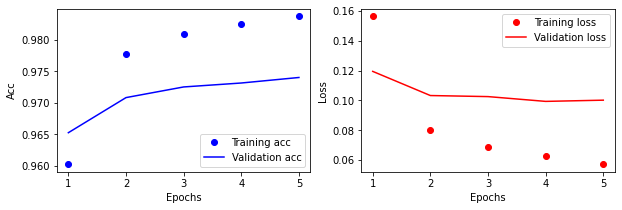

In [ ]:
# plot model fitting results
import matplotlib.pyplot as plt
#%matplotlib inline

fig = plt.figure(figsize = (10,3))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.subplot(1,2,2)
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
fig.savefig(model_dir + model_name + '.png', dpi=400, bbox_inches='tight')

### Evaluate the model

In [ ]:
print('Original test set shape:', x_test.shape)
# how many rows we need extra so that model is divisible by 32
additional_rows = batch_size - x_test.shape[0] % batch_size
x_eval = np.append(x_test, x_test[0:additional_rows], axis=0)
print('Eval test set shape:', x_eval.shape)

Original test set shape: (2443, 50)
Eval test set shape: (2464, 50)


In [ ]:
model = build_model()

# must initialize the model first, then load the weights
model.load_weights(model_dir + model_name + '.h5')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50)                0         
_________________________________________________________________
lambda_2 (Lambda)            (None, None, 1024)        0         
_________________________________________________________________
dense_3 (Dense)              (None, None, 256)         262400    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
dense_4 (Dense)              (None, None, 25)          6425      
Total params: 268,825
Trainable params: 268,825
Non-trainable params: 0
_________________________________________________________________


In [ ]:
preds = model.predict(x_eval, batch_size=batch_size)
preds.shape

(2464, 50, 25)

In [ ]:
preds = np.argmax(preds, axis=-1)

In [ ]:
print('Initial preds shape:', preds.shape)
preds = preds[0:x_test.shape[0]]
print('Trimmed to original preds shape:', preds.shape)

Initial preds shape: (2464, 50)
Trimmed to original preds shape: (2443, 50)


In [ ]:
# trim the length of docs back to the number of words to predict
trim_preds = []
for i, doc in enumerate(dataset['test_tokens']):
  trim_preds.append(preds[i][0:len(doc)])  

In [ ]:
[idx2tag[pred] for pred in trim_preds[0]]

['O', 'O', 'O', 'O', 'B-GENRE', 'I-GENRE', 'O', 'O', 'O']

In [ ]:
dataset['test_labels'][0]

['O', 'O', 'O', 'O', 'B-GENRE', 'I-GENRE', 'O', 'B-YEAR', 'I-YEAR']

In [ ]:
preds_stretched = [idx2tag[label] for doc in trim_preds for label in doc]
trues_stretched = [label for doc in dataset['test_labels'] for label in doc]

In [ ]:
from sklearn.metrics import classification_report


#f = open(model_dir + model_name  + '_class_report_test.txt', 'w') 

class_report = classification_report(trues_stretched, preds_stretched)
#print(class_report, file=f ) 

#f.close() 


print(class_report)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

          B-ACTOR       0.82      0.93      0.87       812
      B-CHARACTER       0.74      0.26      0.38        90
       B-DIRECTOR       0.86      0.77      0.81       456
          B-GENRE       0.90      0.95      0.92      1117
           B-PLOT       0.67      0.63      0.65       491
         B-RATING       0.97      0.97      0.97       500
B-RATINGS_AVERAGE       0.92      0.89      0.91       451
         B-REVIEW       0.36      0.14      0.21        56
           B-SONG       0.67      0.48      0.56        54
          B-TITLE       0.70      0.71      0.70       562
        B-TRAILER       0.81      0.70      0.75        30
           B-YEAR       0.95      0.94      0.95       720
          I-ACTOR       0.87      0.89      0.88       862
      I-CHARACTER       0.75      0.08      0.14        75
       I-DIRECTOR       0.84      0.83      0.83       496
          I-GENRE       0.92      0.65      0.76       

## Elmo + BiLSTM

In [ ]:
import tensorflow_hub as hub
from keras import backend as K

In [ ]:
K.clear_session()

sess = tf.Session()
K.set_session(sess)

In [ ]:
batch_size = 32
num_labels = len(tag2idx.keys())

In [ ]:
# trim train set to be divisible by batch_size
remainder = y_train.shape[0] % batch_size
cutoff = y_train.shape[0] - remainder

train_limit = cutoff - batch_size*50 # take 100 batches to validate on

x_final_train = x_train[0:train_limit]
y_final_train = y_train[0:train_limit]

x_val = x_train[train_limit:cutoff]
y_val = y_train[train_limit:cutoff]


len(x_final_train), y_final_train.shape # , len(x_val), y_val.shape

(8160, (8160, 50, 1))

### Train the model

In [ ]:
model_name = 'mitmovie_elmo/elmo_biLSTM_5epochs'

In [ ]:
# retrieve elmo word embeddings
# https://tfhub.dev/google/elmo/3

elmo_model = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [ ]:
def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)), # passing the pretokenized words to the model
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

In [ ]:
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Dropout, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda
import keras.layers as layers
from keras.engine import Layer


# Function to build model
def build_model():

  input_text = Input(shape=(max_len,), dtype=tf.string)

  embedding = Lambda(ElmoEmbedding, output_shape=(None, 1024))(input_text)

  x = Bidirectional(LSTM(units=512, return_sequences=True,
                      recurrent_dropout=0.2, dropout=0.2))(embedding)

  x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                          recurrent_dropout=0.2, dropout=0.2))(x)

  x = add([x, x_rnn])  # residual connection to the first biLSTM

  out = TimeDistributed(Dense(num_labels, activation="softmax"))(x)

  model = Model(input_text, out)

  model.compile(optimizer="adam", 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])
  
  model.summary() # print model summary

  return model

In [ ]:
model = build_model()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None, 1024)   0           input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, None, 1024)   6295552     lambda_1[0][0]                   
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, None, 1024)   6295552     bidirectional_1[0][0]            
____________________________________________________________________________________________

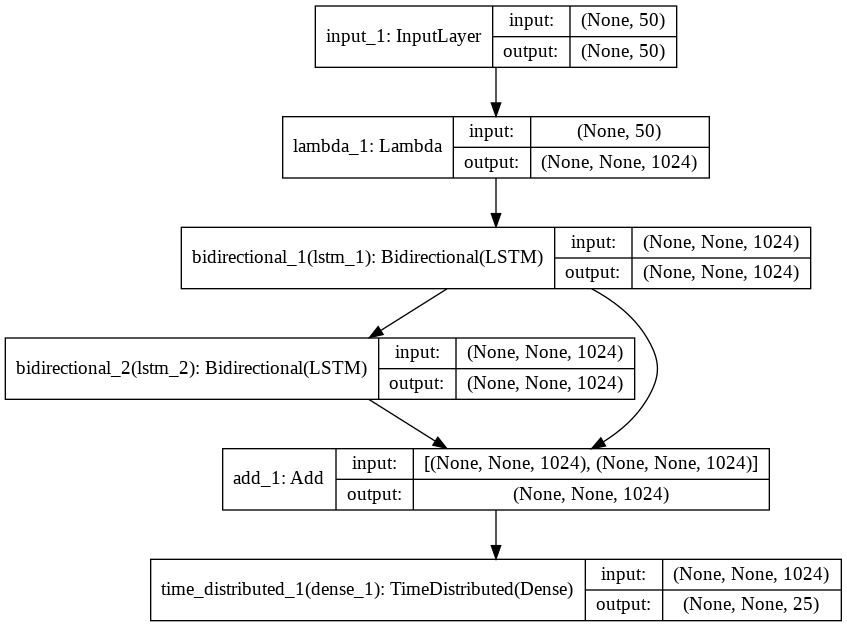

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(x_final_train, y_final_train, 
                    validation_data = (x_val, y_val), 
                    batch_size = batch_size, 
                    epochs = 5)

Train on 8160 samples, validate on 1600 samples
Epoch 1/5
8160/8160 [==============================] - 81s 10ms/step - loss: 0.1308 - accuracy: 0.9664 - val_loss: 0.0477 - val_accuracy: 0.9865
Epoch 2/5
8160/8160 [==============================] - 79s 10ms/step - loss: 0.0569 - accuracy: 0.9841 - val_loss: 0.0502 - val_accuracy: 0.9855
Epoch 3/5
8160/8160 [==============================] - 80s 10ms/step - loss: 0.0460 - accuracy: 0.9868 - val_loss: 0.0408 - val_accuracy: 0.9890
Epoch 4/5
8160/8160 [==============================] - 80s 10ms/step - loss: 0.0385 - accuracy: 0.9889 - val_loss: 0.0392 - val_accuracy: 0.9895
Epoch 5/5
8160/8160 [==============================] - 80s 10ms/step - loss: 0.0326 - accuracy: 0.9900 - val_loss: 0.0407 - val_accuracy: 0.9891


In [ ]:
model.save_weights(model_dir + model_name + '.h5')

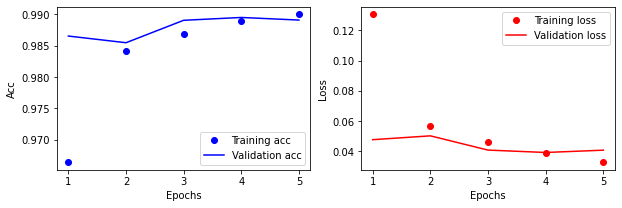

In [ ]:
# plot model fitting results
import matplotlib.pyplot as plt
#%matplotlib inline

fig = plt.figure(figsize = (10,3))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.subplot(1,2,2)
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
fig.savefig(model_dir + model_name + '.png', dpi=400, bbox_inches='tight')

### Evaluate the model

In [ ]:
print('Original test set shape:', x_test.shape)
# how many rows we need extra so that model is divisible by 32
additional_rows = batch_size - x_test.shape[0] % batch_size
x_eval = np.append(x_test, x_test[0:additional_rows], axis=0)
print('Eval test set shape:', x_eval.shape)

Original test set shape: (2443, 50)
Eval test set shape: (2464, 50)


In [ ]:
model = build_model()

# must initialize the model first, then load the weights
model.load_weights(model_dir + model_name + '.h5')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, None, 1024)   0           input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, None, 1024)   6295552     lambda_2[0][0]                   
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, None, 1024)   6295552     bidirectional_3[0][0]            
____________________________________________________________________________________________

In [ ]:
preds = model.predict(x_eval, batch_size=batch_size)
preds = np.argmax(preds, axis=-1)

In [ ]:
print('Initial preds shape:', preds.shape)
preds = preds[0:x_test.shape[0]]
print('Trimmed to original preds shape:', preds.shape)

Initial preds shape: (2464, 50)
Trimmed to original preds shape: (2443, 50)


In [ ]:
# trim the length of docs back to the number of words to predict
trim_preds = []
for i, doc in enumerate(dataset['test_tokens']):
  trim_preds.append(preds[i][0:len(doc)])  

In [ ]:
preds_stretched = [idx2tag[label] for doc in trim_preds for label in doc]
trues_stretched = [label for doc in dataset['test_labels'] for label in doc]

len(preds_stretched), len(trues_stretched)

(24686, 24686)

In [ ]:
from sklearn.metrics import classification_report


f = open(model_dir + model_name  + '_class_report_test.txt', 'w') 

class_report = classification_report(trues_stretched, preds_stretched)
print(class_report, file=f ) 

f.close() 


print(class_report)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

          B-ACTOR       0.89      0.92      0.90       812
      B-CHARACTER       0.61      0.52      0.56        90
       B-DIRECTOR       0.89      0.84      0.86       456
          B-GENRE       0.93      0.95      0.94      1117
           B-PLOT       0.74      0.70      0.72       491
         B-RATING       0.98      0.97      0.97       500
B-RATINGS_AVERAGE       0.94      0.91      0.92       451
         B-REVIEW       0.38      0.27      0.32        56
           B-SONG       0.83      0.63      0.72        54
          B-TITLE       0.90      0.80      0.84       562
        B-TRAILER       0.79      0.63      0.70        30
           B-YEAR       0.96      0.94      0.95       720
          I-ACTOR       0.87      0.90      0.88       862
      I-CHARACTER       0.51      0.41      0.46        75
       I-DIRECTOR       0.83      0.88      0.85       496
          I-GENRE       0.90      0.73      0.80       

In [ ]:
!pip install seqeval

     |████████████████████████████████| 51kB 4.1MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=ed9ad171137876d5187c0575f345d9692d796b9ebef982ff00df6ee6dfcf65f9
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [ ]:
seq_preds = []
for doc in trim_preds:
  seq_preds.append([idx2tag[val] for val in doc])

In [ ]:
seq_preds[0]

['O', 'O', 'O', 'O', 'B-GENRE', 'I-GENRE', 'O', 'O', 'O']

In [ ]:
from seqeval.metrics import classification_report as classification_report_seqeval

f = open(model_dir + model_name  + 'seq_class_report_test.txt', 'w') 

seq_class_report = classification_report_seqeval(dataset['test_labels'], seq_preds)
print(seq_class_report, file=f ) 

f.close() 
print(seq_class_report)

                 precision    recall  f1-score   support

          ACTOR       0.81      0.87      0.84       812
      CHARACTER       0.48      0.49      0.49        90
       DIRECTOR       0.77      0.84      0.80       456
          GENRE       0.89      0.92      0.91      1117
           PLOT       0.63      0.67      0.65       491
         RATING       0.94      0.93      0.93       500
RATINGS_AVERAGE       0.83      0.84      0.84       451
         REVIEW       0.22      0.16      0.19        56
           SONG       0.46      0.44      0.45        54
          TITLE       0.74      0.76      0.75       562
        TRAILER       0.79      0.63      0.70        30
           YEAR       0.95      0.94      0.94       720

      micro avg       0.82      0.84      0.83      5339
      macro avg       0.71      0.71      0.71      5339
   weighted avg       0.82      0.84      0.83      5339



### Interpret the Model
use eli5 package implementation of LIME algorithm to visualize contributors to the classification of entities
Guidance for how to do interpretability with NER was taken from: https://www.depends-on-the-definition.com/interpretable-named-entity-recognition/

Assign the sentence and the word to inspect

In [ ]:
# get sample sentence
# eli5 algorithm uses a str as the initial feed
sentenceStr =  ' '.join( dataset['train_tokens'][6] ) # assign by index value [#]
sentenceStr

In [ ]:
# get token number of word to evaluate - 'fiction'
word_to_check = 3

Define the predicting function.
eli5 is expecting a return of the class probabilities for word_to_check (word_to_check is established at program level, not function level

In [ ]:
def make_predictions(texts): #eli5 will pass n_samples of str
  
  textLists = [text.split() for text in texts] # make a list of lists to pass the eli5 str sentences
  
  #########################################
  # pad the sentences as earlier, the model requires padded sentences
  new_X = []
  for seq in textLists:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("__PAD__")
    new_X.append(new_seq)
    
  x_test = np.array(new_X)

  ##########################################
  # NOTE: the model is using a batch size of 32, tell eli5 to pass a multiple of 32 n_samples
  # to improve future robustness, code to ensure a multiple of batch size by appending repeat sentences

  #########################################
  # make the predictions

  preds = model.predict(x_test, batch_size=batch_size)

  return preds[:,word_to_check,:]# return probs only for the word you want
  # note: word_to_check is established at higher context level, not passed to the function
  # eli5 setup does not pass in supplemental arguments

In [ ]:
!pip install eli5
from eli5.lime import TextExplainer
from eli5.lime.samplers import MaskingTextSampler

     |████████████████████████████████| 112kB 7.8MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# define the masking sampler to use in the eli5 text explainer

sampler = MaskingTextSampler(
    replacement = "UNK",
    max_replace = 0.7,
    bow = False # bag of words means it will test the exclusion of multiple words as well
)

In [ ]:
# Define the eli5 Text Explainer
# NOTE: the Model uses a batch size of batch_size (32) - set n_samples to a multiple of batch_size (default is 5000)
# ALTERNATE TO IMPROVE ROBUSTNESS - modify the make_predictions function to account for any variation

te = TextExplainer(n_samples=4096, sampler=sampler, position_dependent = True, random_state=53)
te.fit(doc=sentenceStr, predict_proba=make_predictions)


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


TextExplainer(char_based=False,
              clf=SGDClassifier(alpha=0.001, average=False, class_weight=None,
                                early_stopping=False, epsilon=0.1, eta0=0.0,
                                fit_intercept=True, l1_ratio=0.15,
                                learning_rate='optimal', loss='log',
                                max_iter=1000, n_iter_no_change=5, n_jobs=None,
                                penalty='elasticnet', power_t=0.5,
                                random_state=RandomState(MT19937) at 0x7F2E32A6B150,
                                shuffle=True, tol=0.001,
                                validation_fraction=0.1, verbose=0,
                                warm_start=False),
              expand_factor=10, n_samples=4096, position_dependent=True,
              random_state=53, rbf_sigma=None,
              sampler=MaskingTextSampler(bow=False, group_size=1,
                                         max_replace=0.7, min_replace=1,
         

In [ ]:
# get classification labels
eli5_labels=np.unique(labels_stretched).tolist()

In [ ]:
te.show_prediction(target_names=eli5_labels, top_targets=3)

## Elmo + BiLSTM + CRF

In [ ]:
import tensorflow_hub as hub
from keras import backend as K

In [ ]:
K.clear_session()

sess = tf.Session()
K.set_session(sess)

In [ ]:
batch_size = 32
num_labels = len(tag2idx.keys())
num_labels

25

In [ ]:
# trim train set to be divisible by batch_size
remainder = y_train.shape[0] % batch_size
cutoff = y_train.shape[0] - remainder

#train_limit = cutoff - batch_size*10 # take 10 batches to validate on

x_final_train = x_train[0:cutoff]
y_final_train = y_train[0:cutoff]

#x_val = x_train[train_limit:cutoff]
#y_val = y_train[train_limit:cutoff]


len(x_final_train), y_final_train.shape # , len(x_val), y_val.shape

(9760, (9760, 50, 1))

In [ ]:
from keras.utils import to_categorical

# must go back and rerun begining steps but skip reshaping y
y = [to_categorical(i, num_classes = num_labels + 1) for i in y_train]

### Train the model

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-bmbuz505
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-bmbuz505
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=5643cc4cc2309f990cab152e0d3a1fd941c286bac8d326f19d31e8a928c04c5c
  Stored in directory: /tmp/pip-ephem-wheel-cache-tjmieknt/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [ ]:
model_name = 'mitmovie_elmo/elmo_biLSTM_CRF_5epochs'

In [ ]:
# retrieve elmo word embeddings
# https://tfhub.dev/google/elmo/3

elmo_model = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [ ]:
def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)), # passing the pretokenized words to the model
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

In [ ]:
num_labels

25

In [ ]:
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Dropout, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda
from keras_contrib.layers import CRF
import keras.layers as layers
from keras.engine import Layer


# Function to build model
def build_model():

  input_text = Input(shape=(max_len,), dtype=tf.string)

  embedding = Lambda(ElmoEmbedding, output_shape=(None, 1024))(input_text)

  # x = Bidirectional(LSTM(units=512, return_sequences=True,
  #                     recurrent_dropout=0.2, dropout=0.2))(embedding)

  # x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
  #                         recurrent_dropout=0.2, dropout=0.2))(x)

  # x = add([x, x_rnn])  # residual connection to the first biLSTM

  # out = TimeDistributed(Dense(num_labels, activation="softmax"))(x)


  bi = Bidirectional(LSTM(units = 50, return_sequences=True, 
                             recurrent_dropout=0.2))(embedding)

#  tdist = TimeDistributed(Dense(50, activation="relu"))(bi)
  tdist = TimeDistributed(Dense(num_labels, activation="relu"))(bi)

#  out = TimeDistributed(Dense(num_labels, activation="softmax"))(x)
  crf = CRF(num_labels)  # CRF layer
#  crf = CRF(num_labels+1)  # CRF layer
  out = crf(tdist)  # output    

  model = Model(input_text, out)

  model.compile(optimizer="rmsprop", 
              loss=crf.loss_function, 
              metrics=[crf.accuracy])
  
  model.summary() # print model summary

  return model

In [ ]:
model = build_model()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 50)                0         
_________________________________________________________________
lambda_3 (Lambda)            (None, None, 1024)        0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 100)         430000    
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 25)          2525      
_________________________________________________________________
crf_3 (CRF)                  (None, None, 25)          1325      
Total params: 433,850
Trainable params: 433,850
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_final_train, y_final_train, 
                    #validation_data = (x_val, y_val), 
                    batch_size = batch_size, 
                    epochs = 5)

Epoch 1/5


InvalidArgumentError: ignored

In [ ]:
model.save_weights(model_dir + model_name + '.h5')

In [ ]:
# plot model fitting results
import matplotlib.pyplot as plt
#%matplotlib inline

fig = plt.figure(figsize = (10,3))

acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.subplot(1,2,2)
loss = history.history['loss']
#val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'ro', label='Training loss')
#plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
#plt.ylabel('Loss')
plt.legend()

plt.show()
fig.savefig(model_dir + model_name + '.png', dpi=400, bbox_inches='tight')

### Evaluate the model

In [ ]:
print('Original test set shape:', x_test.shape)
# how many rows we need extra so that model is divisible by 32
additional_rows = batch_size - x_test.shape[0] % batch_size
x_eval = np.append(x_test, x_test[0:additional_rows], axis=0)
print('Eval test set shape:', x_eval.shape)

In [ ]:
model = build_model()

# must initialize the model first, then load the weights
model.load_weights(model_dir + model_name + '.h5')

In [ ]:
preds = model.predict(x_eval, batch_size=batch_size)
preds = np.argmax(preds, axis=-1)

In [ ]:
print('Initial preds shape:', preds.shape)
preds = preds[0:x_test.shape[0]]
print('Trimmed to original preds shape:', preds.shape)

In [ ]:
# trim the length of docs back to the number of words to predict
trim_preds = []
for i, doc in enumerate(dataset['test_tokens']):
  trim_preds.append(preds[i][0:len(doc)])  

In [ ]:
preds_stretched = [idx2tag[label] for doc in trim_preds for label in doc]
trues_stretched = [label for doc in dataset['test_labels'] for label in doc]

len(preds_stretched), len(trues_stretched)

In [ ]:
from sklearn.metrics import classification_report


#f = open(model_dir + model_name  + '_class_report_test.txt', 'w') 

class_report = classification_report(trues_stretched, preds_stretched)
#print(class_report, file=f ) 

#f.close() 


print(class_report)